# t-SNE examples implemented with openTSNE

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import plotly.graph_objects as go
import matplotlib.colors as mcolors
import pyreadr
import pickle
import pandas as pd
from scipy.stats import pearsonr, gaussian_kde

from d_and_c.d_and_c import divide_conquer
from d_and_c.methods import DRMethod, tsne
from d_and_c.private_d_and_c import perform_procrustes
from d_and_c.utils import benchmark, runif_in_tetrahedron
from scipy.spatial.distance import pdist, squareform
from sklearn.datasets import make_swiss_roll

np.random.seed(42)
pickle_path = os.path.join(os.getcwd(), "pickles")
os.makedirs(pickle_path, exist_ok=True)

## 1. Two clusters with equal number of points
from https://distill.pub/2016/misread-tsne/ 

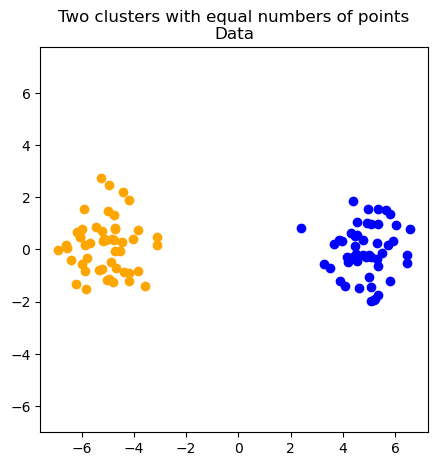

In [3]:
# Generate data
n_points = 100
n_per_cluster = n_points // 2

cluster1 = np.random.randn(n_per_cluster, 2) + np.array([5, 0])
cluster2 = np.random.randn(n_per_cluster, 2) + np.array([-5, 0])
two_clusters = np.vstack((cluster1, cluster2))

# Plot data
plt.figure(figsize=(5, 5))
plt.scatter(two_clusters[:n_per_cluster, 0], two_clusters[:n_per_cluster, 1],
            color='blue', label='Cluster 1')
plt.scatter(two_clusters[n_per_cluster:, 0], two_clusters[n_per_cluster:, 1],
            color='orange', label='Cluster 2')
plt.title('Two clusters with equal numbers of points\nData')
plt.axis('equal')
plt.show()

In [4]:
# Apply t-SNE
%time two_clusters_embedding = tsne(two_clusters, perplexity=30, n_iter=5000, learning_rate=10, random_state=42)

CPU times: user 26.4 s, sys: 3min 24s, total: 3min 50s
Wall time: 1min


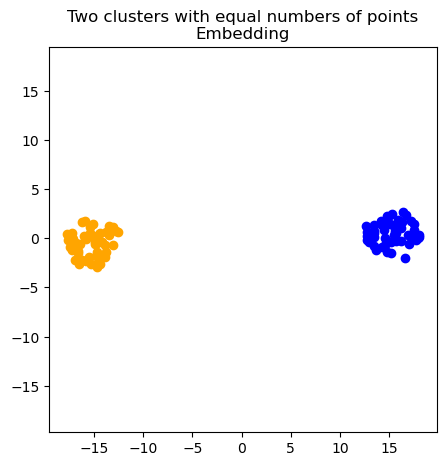

In [5]:
# Plot the t-SNE embedding
plt.figure(figsize=(5, 5))
plt.scatter(two_clusters_embedding[:n_per_cluster, 0], two_clusters_embedding[:n_per_cluster, 1],
            color='blue', label='Cluster 1')
plt.scatter(two_clusters_embedding[n_per_cluster:, 0], two_clusters_embedding[n_per_cluster:, 1],
            color='orange', label='Cluster 2')
plt.title('Two clusters with equal numbers of points\nEmbedding')
plt.axis('equal')
plt.show()

## 2. Random Gaussian walk
from https://distill.pub/2016/misread-tsne/ 

In [6]:
# Generate a random Gaussian walk
n_points = 100
n_dims = 100

walk = np.zeros((n_points, n_dims))
for i in range(1, n_points):
    walk[i] = walk[i-1] + np.random.randn(n_dims)

In [7]:
# Apply t-SNE
%time walk_embedding = tsne(walk, perplexity=10, n_iter=5000, learning_rate=5, random_state=42)

CPU times: user 25.5 s, sys: 3min 13s, total: 3min 38s
Wall time: 56.5 s


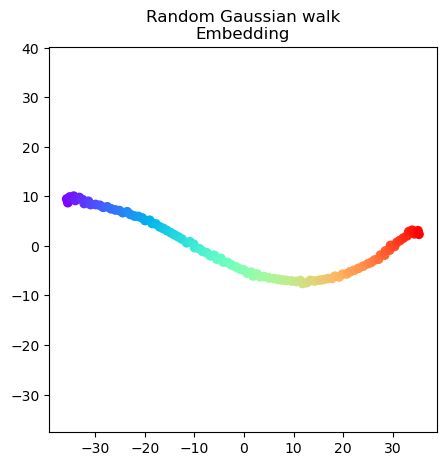

In [8]:
# Plot the t-SNE embedding
plt.figure(figsize=(5, 5))
plt.scatter(walk_embedding[:, 0], walk_embedding[:, 1],
            c=np.arange(n_points), cmap='rainbow')
plt.title('Random Gaussian walk\nEmbedding')
plt.axis('equal')
plt.show()

## 3. Tetrahedron

### 3.0 Tetrahedron vertices

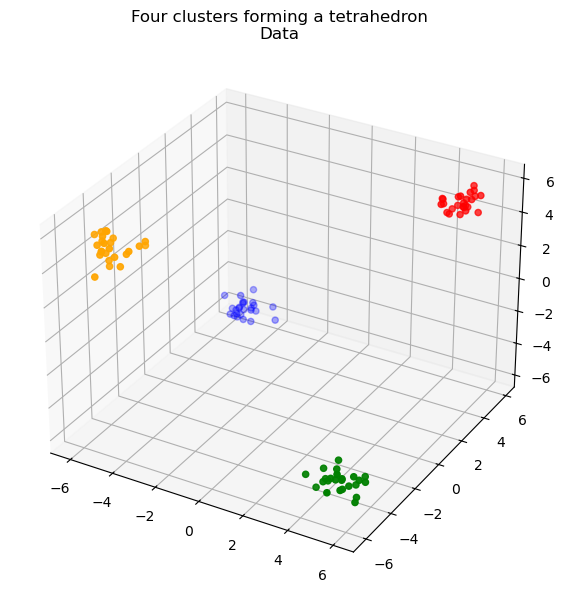

In [60]:
## Generate data
n_points = 100
points_per_cluster = n_points // 4

# Define vertices of a tetrahedron
vertices = np.array([
    [1, 1, 1],
    [1, -1, -1],
    [-1, 1, -1],
    [-1, -1, 1]
]) * 5


# Generate clusters with gaussian noise around each vertex
clusters = []
for vertex in vertices:
    cluster = np.random.randn(points_per_cluster, 3) * 0.5 + vertex
    clusters.append(cluster)
tetrahedron = np.vstack(clusters)

colors = ['red', 'green', 'blue', 'orange']
cluster_colors = np.repeat(colors, points_per_cluster)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tetrahedron[:,0], tetrahedron[:,1], tetrahedron[:,2],
            color=cluster_colors)
ax.set_title('Four clusters forming a tetrahedron\nData')
plt.show()

In [61]:
distances = squareform(pdist(vertices)); distances

array([[ 0.        , 14.14213562, 14.14213562, 14.14213562],
       [14.14213562,  0.        , 14.14213562, 14.14213562],
       [14.14213562, 14.14213562,  0.        , 14.14213562],
       [14.14213562, 14.14213562, 14.14213562,  0.        ]])

In [62]:
vertices2 = [[0,0,0], [1,0,0], [0,0,1], [0,1,0]]
distances2 = squareform(pdist(vertices2)); distances2

array([[0.        , 1.        , 1.        , 1.        ],
       [1.        , 0.        , 1.41421356, 1.41421356],
       [1.        , 1.41421356, 0.        , 1.41421356],
       [1.        , 1.41421356, 1.41421356, 0.        ]])

In [63]:
vertices3 = [[1,1,1], [1,0,0], [0,1,0], [0,0,1]]
distances3 = squareform(pdist(vertices3)); distances3

array([[0.        , 1.41421356, 1.41421356, 1.41421356],
       [1.41421356, 0.        , 1.41421356, 1.41421356],
       [1.41421356, 1.41421356, 0.        , 1.41421356],
       [1.41421356, 1.41421356, 1.41421356, 0.        ]])

In [64]:
# Regular tetrahedron with v1=(0,0,0)
v1 = np.array([0, 0, 0])
v2 = np.array([1, 0, 0])
v3 = np.array([0.5, np.sqrt(3)/2, 0])
v4 = np.array([0.5, np.sqrt(3)/6, np.sqrt(6)/3])
vertices4 = np.stack([v1, v2, v3, v4], axis=0)
distances4 = squareform(pdist(vertices4)); distances4

array([[0., 1., 1., 1.],
       [1., 0., 1., 1.],
       [1., 1., 0., 1.],
       [1., 1., 1., 0.]])

In [65]:
## Apply t-SNE
# random_state=1
%time tetrahedron_embedding_rs1_1 = tsne(tetrahedron, r=2, perplexity=10, n_iter=5000, learning_rate=5, random_state=1)
%time tetrahedron_embedding_rs1_2 = tsne(tetrahedron, r=2, perplexity=20, n_iter=5000, learning_rate=5, random_state=1)
%time tetrahedron_embedding_rs1_3 = tsne(tetrahedron, r=2, perplexity=10, n_iter=5000, learning_rate=10, random_state=1)
%time tetrahedron_embedding_rs1_4 = tsne(tetrahedron, r=2, perplexity=20, n_iter=5000, learning_rate=10, random_state=1)

# random_state=2
%time tetrahedron_embedding_rs2_1 = tsne(tetrahedron, r=2, perplexity=10, n_iter=5000, learning_rate=5, random_state=2)
%time tetrahedron_embedding_rs2_2 = tsne(tetrahedron, r=2, perplexity=20, n_iter=5000, learning_rate=5, random_state=2)
%time tetrahedron_embedding_rs2_3 = tsne(tetrahedron, r=2, perplexity=10, n_iter=5000, learning_rate=10, random_state=2)
%time tetrahedron_embedding_rs2_4 = tsne(tetrahedron, r=2, perplexity=20, n_iter=5000, learning_rate=10, random_state=2)

KeyboardInterrupt: 

: 

: 

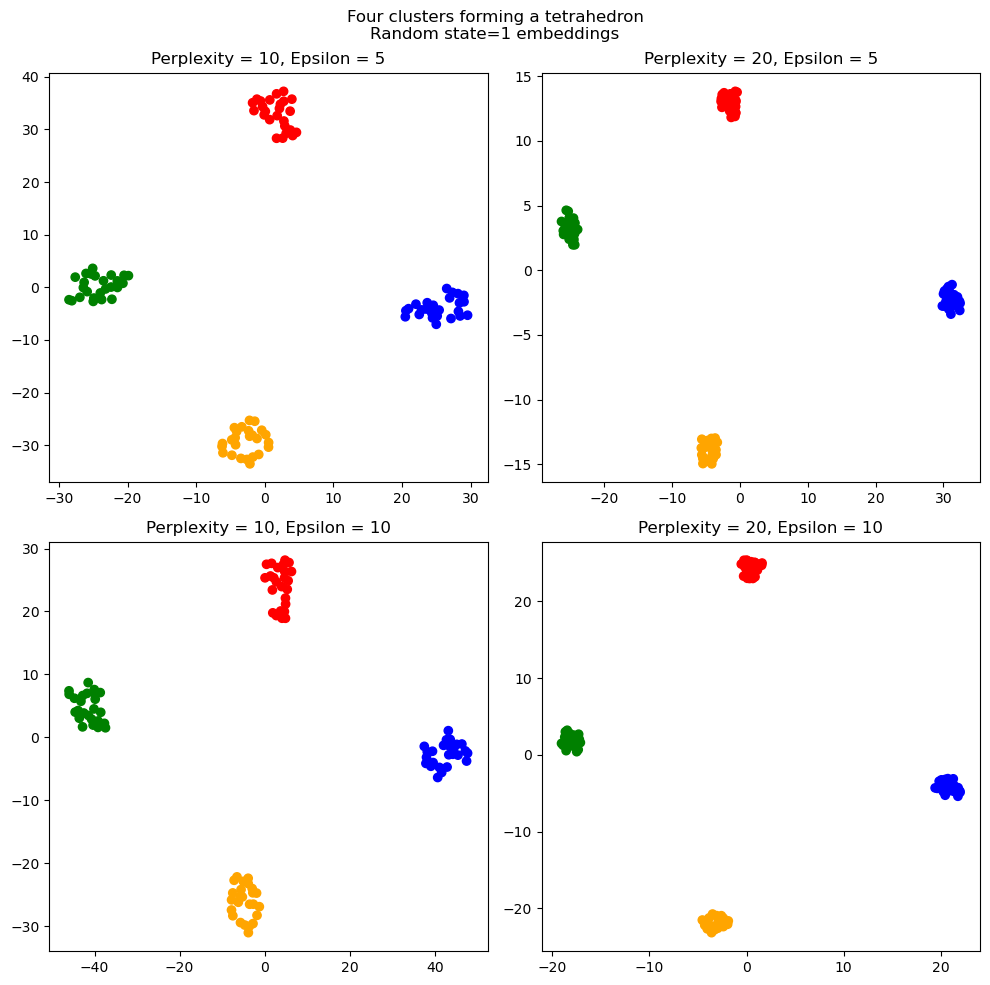

In [ ]:
## Plot the t-SNE embeddings
# random_state=1
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Four clusters forming a tetrahedron\nRandom state=1 embeddings')

ax1 = fig.add_subplot(221)
ax1.scatter(tetrahedron_embedding_rs1_1[:, 0], tetrahedron_embedding_rs1_1[:, 1],
            c=cluster_colors)
ax1.set_title('Perplexity = 10, Epsilon = 5')

ax2 = fig.add_subplot(222)
ax2.scatter(tetrahedron_embedding_rs1_2[:, 0], tetrahedron_embedding_rs1_2[:, 1],
            c=cluster_colors)
ax2.set_title('Perplexity = 20, Epsilon = 5')

ax3 = fig.add_subplot(223)
ax3.scatter(tetrahedron_embedding_rs1_3[:, 0], tetrahedron_embedding_rs1_3[:, 1],
            c=cluster_colors)
ax3.set_title('Perplexity = 10, Epsilon = 10')

ax4 = fig.add_subplot(224)
ax4.scatter(tetrahedron_embedding_rs1_4[:, 0], tetrahedron_embedding_rs1_4[:, 1],
            c=cluster_colors)
ax4.set_title('Perplexity = 20, Epsilon = 10')

fig.tight_layout()

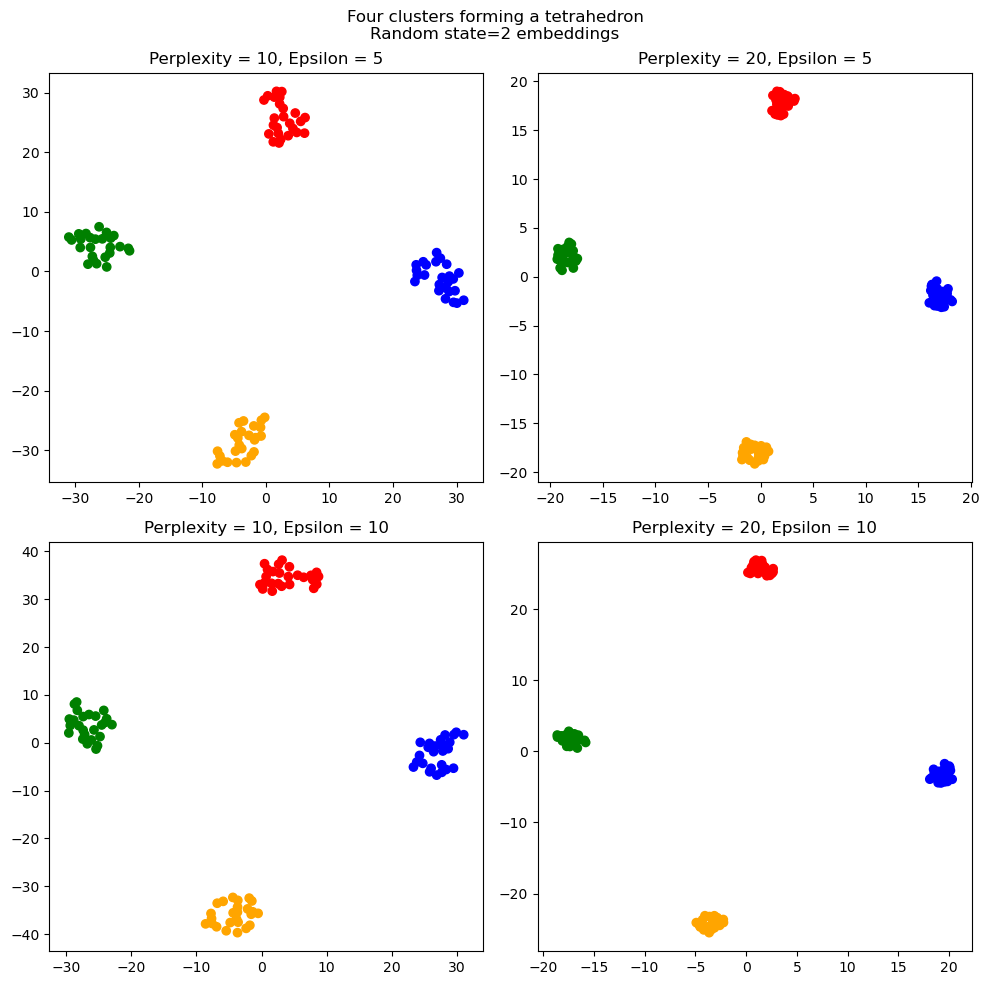

In [ ]:
# random_state=2
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Four clusters forming a tetrahedron\nRandom state=2 embeddings')

ax1 = fig.add_subplot(221)
ax1.scatter(tetrahedron_embedding_rs2_1[:, 0], tetrahedron_embedding_rs2_1[:, 1],
            c=cluster_colors)
ax1.set_title('Perplexity = 10, Epsilon = 5')

ax2 = fig.add_subplot(222)
ax2.scatter(tetrahedron_embedding_rs2_2[:, 0], tetrahedron_embedding_rs2_2[:, 1],
            c=cluster_colors)
ax2.set_title('Perplexity = 20, Epsilon = 5')

ax3 = fig.add_subplot(223)
ax3.scatter(tetrahedron_embedding_rs2_3[:, 0], tetrahedron_embedding_rs2_3[:, 1],
            c=cluster_colors)
ax3.set_title('Perplexity = 10, Epsilon = 10')

ax4 = fig.add_subplot(224)
ax4.scatter(tetrahedron_embedding_rs2_4[:, 0], tetrahedron_embedding_rs2_4[:, 1],
            c=cluster_colors)
ax4.set_title('Perplexity = 20, Epsilon = 10')

fig.tight_layout()

The vertices order is consistent across different parameters and random states. Finally, we will run the same experiments on a newly generated tetrahedron.

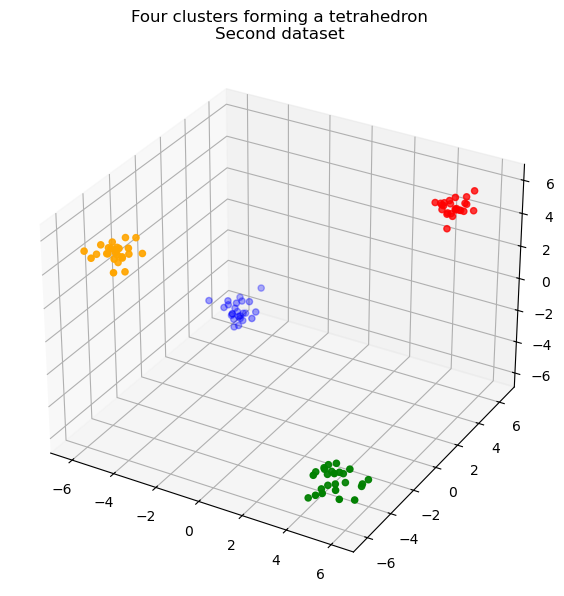

In [ ]:
# Generate new tetrahedron
clusters2 = []
for vertex in vertices:
    cluster = np.random.randn(points_per_cluster, 3) * 0.5 + vertex
    clusters2.append(cluster)
tetrahedron2 = np.vstack(clusters2)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tetrahedron2[:, 0], tetrahedron2[:, 1], tetrahedron2[:, 2],
           color=cluster_colors)
ax.set_title('Four clusters forming a tetrahedron\nSecond dataset')
plt.show()

In [ ]:
## Apply t-SNE on the second dataset
# random_state=1
%time tetrahedron2_embedding_rs1_1 = tsne(tetrahedron2, r=2, perplexity=10, n_iter=5000, learning_rate=5, random_state=1)
%time tetrahedron2_embedding_rs1_2 = tsne(tetrahedron2, r=2, perplexity=20, n_iter=5000, learning_rate=5, random_state=1)
%time tetrahedron2_embedding_rs1_3 = tsne(tetrahedron2, r=2, perplexity=10, n_iter=5000, learning_rate=10, random_state=1)
%time tetrahedron2_embedding_rs1_4 = tsne(tetrahedron2, r=2, perplexity=20, n_iter=5000, learning_rate=10, random_state=1)

# random_state=2
%time tetrahedron2_embedding_rs2_1 = tsne(tetrahedron2, r=2, perplexity=10, n_iter=5000, learning_rate=5, random_state=2)
%time tetrahedron2_embedding_rs2_2 = tsne(tetrahedron2, r=2, perplexity=20, n_iter=5000, learning_rate=5, random_state=2)
%time tetrahedron2_embedding_rs2_3 = tsne(tetrahedron2, r=2, perplexity=10, n_iter=5000, learning_rate=10, random_state=2)
%time tetrahedron2_embedding_rs2_4 = tsne(tetrahedron2, r=2, perplexity=20, n_iter=5000, learning_rate=10, random_state=2)

CPU times: user 24.2 s, sys: 2min 57s, total: 3min 21s
Wall time: 52.5 s
CPU times: user 24.8 s, sys: 3min 2s, total: 3min 27s
Wall time: 54.5 s
CPU times: user 23.2 s, sys: 2min 52s, total: 3min 15s
Wall time: 51.3 s
CPU times: user 25.6 s, sys: 3min 17s, total: 3min 43s
Wall time: 57.6 s
CPU times: user 21.6 s, sys: 2min 37s, total: 2min 59s
Wall time: 47.3 s
CPU times: user 24.6 s, sys: 3min 8s, total: 3min 32s
Wall time: 55.2 s
CPU times: user 23.3 s, sys: 2min 56s, total: 3min 19s
Wall time: 51.7 s
CPU times: user 26.2 s, sys: 3min 24s, total: 3min 50s
Wall time: 59.5 s


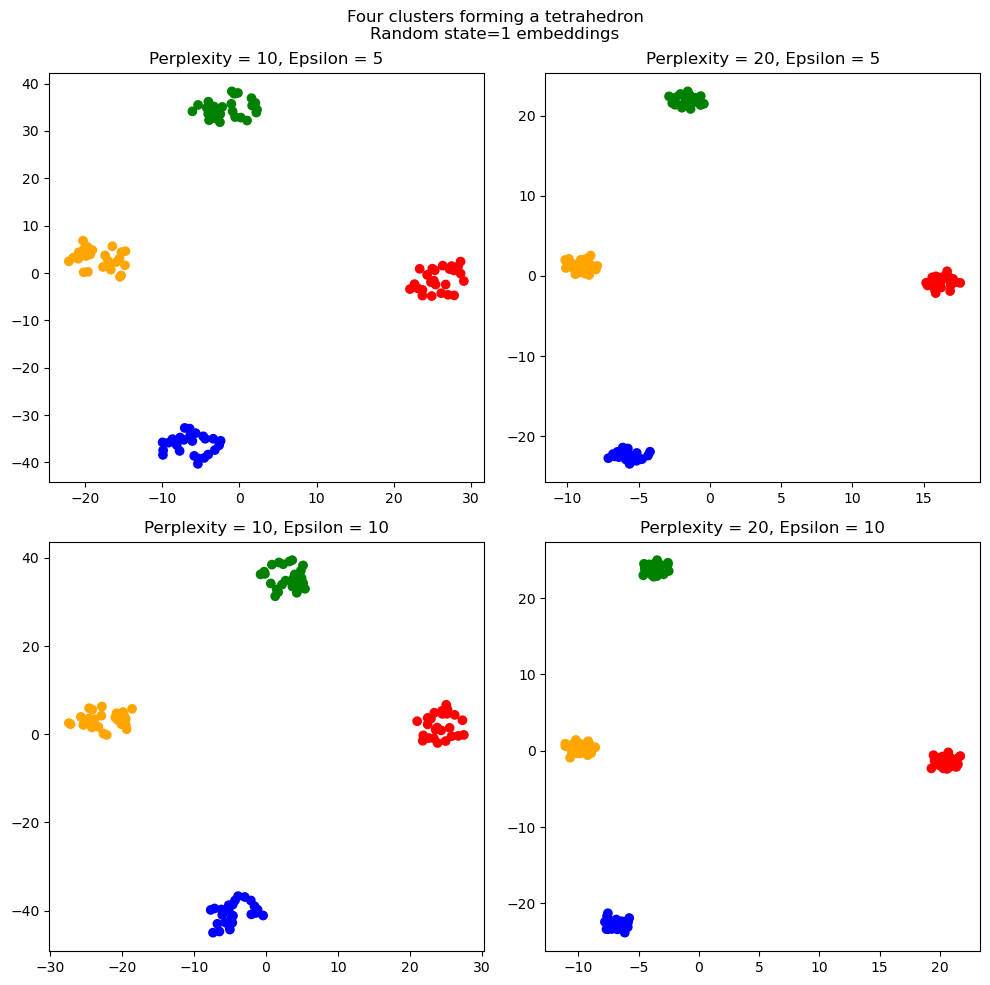

In [ ]:
# Plot the t-SNE embeddings of the second dataset
# random_state=1
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Four clusters forming a tetrahedron\nRandom state=1 embeddings')

ax1 = fig.add_subplot(221)
ax1.scatter(tetrahedron2_embedding_rs1_1[:, 0], tetrahedron2_embedding_rs1_1[:, 1],
            c=cluster_colors)
ax1.set_title('Perplexity = 10, Epsilon = 5')

ax2 = fig.add_subplot(222)
ax2.scatter(tetrahedron2_embedding_rs1_2[:, 0], tetrahedron2_embedding_rs1_2[:, 1],
            c=cluster_colors)
ax2.set_title('Perplexity = 20, Epsilon = 5')

ax3 = fig.add_subplot(223)
ax3.scatter(tetrahedron2_embedding_rs1_3[:, 0], tetrahedron2_embedding_rs1_3[:, 1],
            c=cluster_colors)
ax3.set_title('Perplexity = 10, Epsilon = 10')

ax4 = fig.add_subplot(224)
ax4.scatter(tetrahedron2_embedding_rs1_4[:, 0], tetrahedron2_embedding_rs1_4[:, 1],
            c=cluster_colors)
ax4.set_title('Perplexity = 20, Epsilon = 10')

fig.tight_layout()

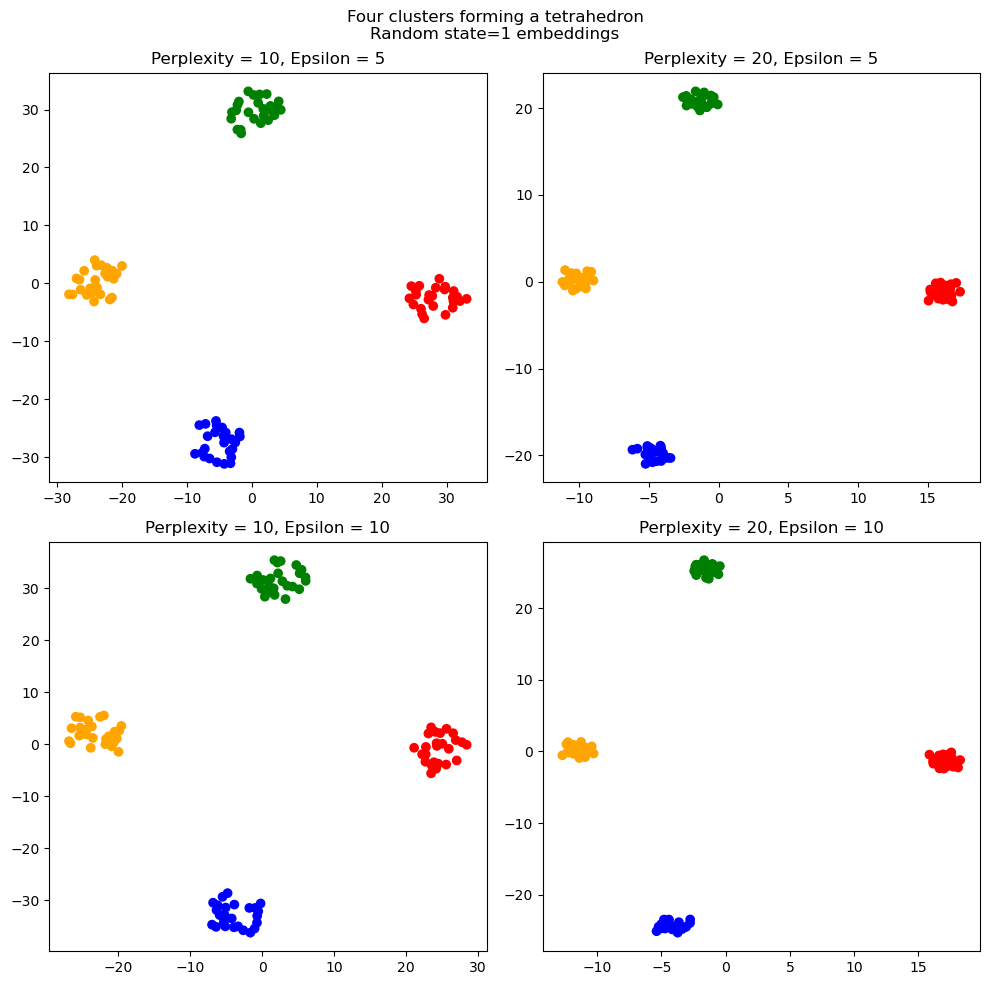

In [ ]:
# Plot the t-SNE embeddings of the second dataset
# random_state=1
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Four clusters forming a tetrahedron\nRandom state=1 embeddings')

ax1 = fig.add_subplot(221)
ax1.scatter(tetrahedron2_embedding_rs2_1[:, 0], tetrahedron2_embedding_rs2_1[:, 1],
            c=cluster_colors)
ax1.set_title('Perplexity = 10, Epsilon = 5')

ax2 = fig.add_subplot(222)
ax2.scatter(tetrahedron2_embedding_rs2_2[:, 0], tetrahedron2_embedding_rs2_2[:, 1],
            c=cluster_colors)
ax2.set_title('Perplexity = 20, Epsilon = 5')

ax3 = fig.add_subplot(223)
ax3.scatter(tetrahedron2_embedding_rs2_3[:, 0], tetrahedron2_embedding_rs2_3[:, 1],
            c=cluster_colors)
ax3.set_title('Perplexity = 10, Epsilon = 10')

ax4 = fig.add_subplot(224)
ax4.scatter(tetrahedron2_embedding_rs2_4[:, 0], tetrahedron2_embedding_rs2_4[:, 1],
            c=cluster_colors)
ax4.set_title('Perplexity = 20, Epsilon = 10')

fig.tight_layout()

It looks like slight changes in the dataset can vary the vertices order. Let us generate more datasets and see if opposite vertices can become adjacent.

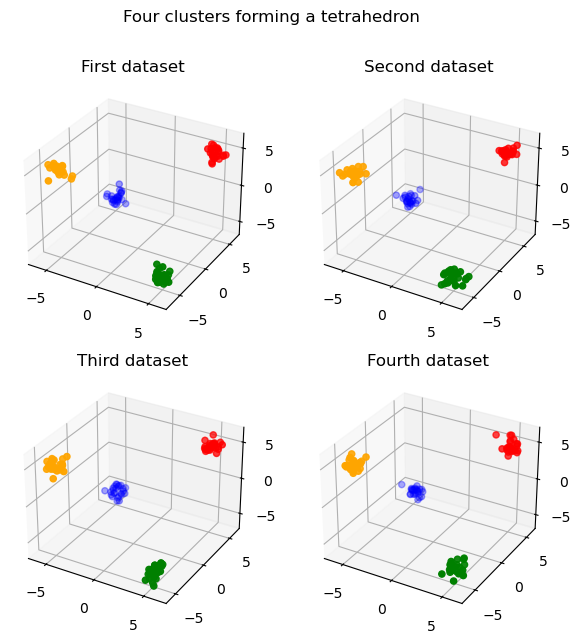

In [ ]:
# Generate new datasets
clusters3 = []
for vertex in vertices:
    cluster = np.random.randn(points_per_cluster, 3) * 0.5 + vertex
    clusters3.append(cluster)
tetrahedron3 = np.vstack(clusters3)

clusters4 = []
for vertex in vertices:
    cluster = np.random.randn(points_per_cluster, 3) * 0.5 + vertex
    clusters4.append(cluster)
tetrahedron4 = np.vstack(clusters4)

fig = plt.figure(figsize=(7, 7))
fig.suptitle('Four clusters forming a tetrahedron')

ax1 = fig.add_subplot(221, projection='3d')
ax1.scatter(tetrahedron[:, 0], tetrahedron[:, 1], tetrahedron[:, 2],
           color=cluster_colors)
ax1.set_title('First dataset')

ax2 = fig.add_subplot(222, projection='3d')
ax2.scatter(tetrahedron2[:, 0], tetrahedron2[:, 1], tetrahedron2[:, 2],
            color=cluster_colors)
ax2.set_title('Second dataset')

ax3 = fig.add_subplot(223, projection='3d')
ax3.scatter(tetrahedron3[:, 0], tetrahedron3[:, 1], tetrahedron3[:, 2],
            color=cluster_colors)
ax3.set_title('Third dataset')

ax4 = fig.add_subplot(224, projection='3d')
ax4.scatter(tetrahedron4[:, 0], tetrahedron4[:, 1], tetrahedron4[:, 2],
            color=cluster_colors)
ax4.set_title('Fourth dataset')
plt.show()

In [ ]:
# Apply t-SNE to different datasets
%time tetrahedron1_embedding = tsne(tetrahedron, r=2, perplexity=20, n_iter=5000, learning_rate=5, random_state=42)
%time tetrahedron2_embedding = tsne(tetrahedron2, r=2, perplexity=20, n_iter=5000, learning_rate=5, random_state=42)
%time tetrahedron3_embedding = tsne(tetrahedron3, r=2, perplexity=20, n_iter=5000, learning_rate=5, random_state=42)
%time tetrahedron4_embedding = tsne(tetrahedron4, r=2, perplexity=20, n_iter=5000, learning_rate=5, random_state=42)

CPU times: user 23.1 s, sys: 2min 45s, total: 3min 8s
Wall time: 49.7 s
CPU times: user 25.8 s, sys: 3min 11s, total: 3min 36s
Wall time: 57.6 s
CPU times: user 22.7 s, sys: 2min 49s, total: 3min 12s
Wall time: 49.8 s
CPU times: user 22.7 s, sys: 2min 49s, total: 3min 11s
Wall time: 50.4 s


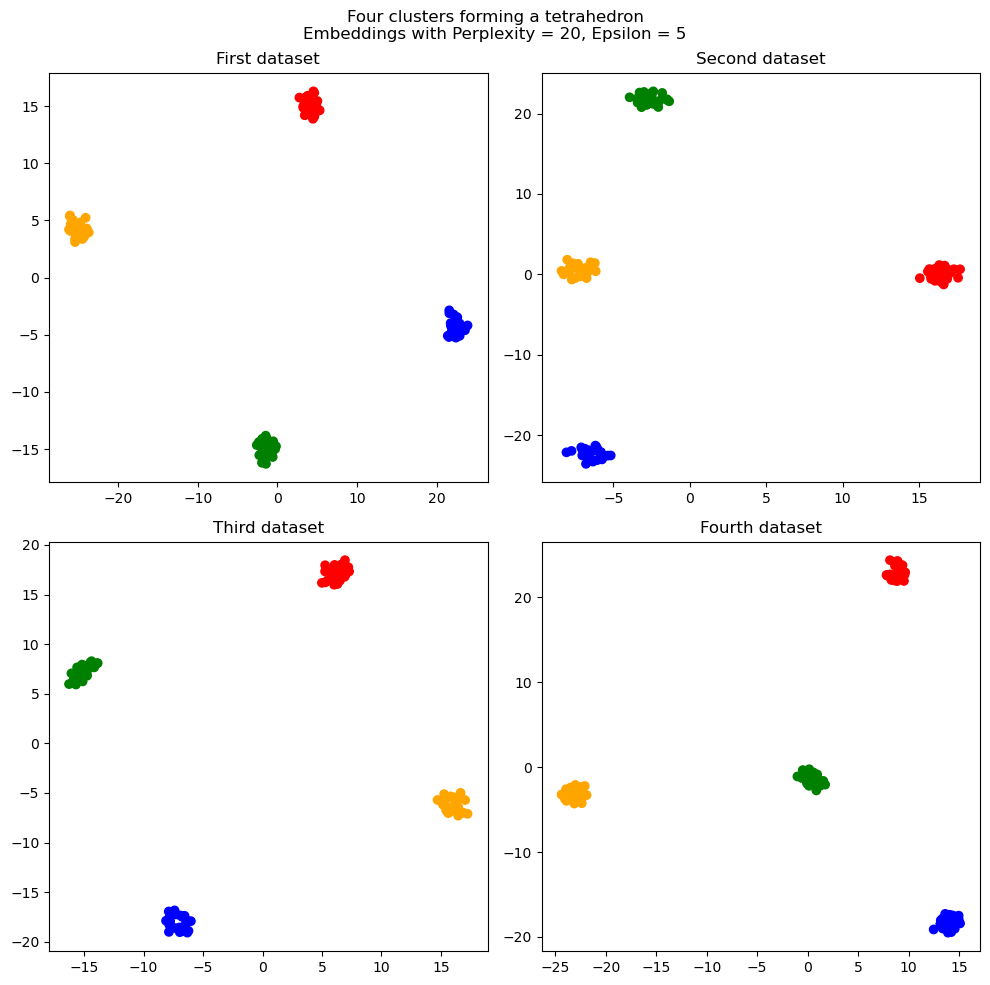

In [ ]:
# Plot the t-SNE embeddings of the four datasets
fig = plt.figure(figsize=(10, 10))
fig.suptitle(
    'Four clusters forming a tetrahedron\nEmbeddings with Perplexity = 20, Epsilon = 5')

ax1 = fig.add_subplot(221)
ax1.scatter(tetrahedron1_embedding[:, 0], tetrahedron1_embedding[:, 1],
            c=cluster_colors)
ax1.set_title('First dataset')

ax2 = fig.add_subplot(222)
ax2.scatter(tetrahedron2_embedding[:, 0], tetrahedron2_embedding[:, 1],
            c=cluster_colors)
ax2.set_title('Second dataset')

ax3 = fig.add_subplot(223)
ax3.scatter(tetrahedron3_embedding[:, 0], tetrahedron3_embedding[:, 1],
            c=cluster_colors)
ax3.set_title('Third dataset')

ax4 = fig.add_subplot(224)
ax4.scatter(tetrahedron4_embedding[:, 0], tetrahedron4_embedding[:, 1],
            c=cluster_colors)
ax4.set_title('Fourth dataset')

fig.tight_layout()

Indeed, we can conclude that slight changes in the dataset can producde significant changes in the embedding. In this case, variations in the noise of each vertex of the tetrahedron may embed a pair of vertices in the high-dimensional space into opposite or adjacent vertices of a square (or even not form a square).

### 3.1 Solid tetrahedron

In [5]:
# Define vertices of a regular tetrahedron with v1 at the origin
vertices = np.array([[0, 0, 0],
                     [1, 0, 0],
                     [0.5, np.sqrt(3)/2, 0],
                     [0.5, np.sqrt(3)/6, np.sqrt(6)/3]
                     ])

# Check the tetrahedron in regular
dist_matrix = squareform(pdist(vertices))
print("Distance matrix between vertices:\n", dist_matrix)

Distance matrix between vertices:
 [[0. 1. 1. 1.]
 [1. 0. 1. 1.]
 [1. 1. 0. 1.]
 [1. 1. 1. 0.]]


In [6]:
# Sample points uniformly at random inside the tetrahedron
solid_tetrahedron = runif_in_tetrahedron(1000, vertices)

In [18]:
# Compute the closest vertex for each point in sims
def get_point_colors(solid_tetrahedron):
    # Use NumPy broadcasting to compute distance between the i-th point and the j-th vertex
    distances = np.linalg.norm(
        solid_tetrahedron[:, None, :] - vertices[None, :, :], axis=2)
    closest_vertex = np.argmin(distances, axis=1)

    # Define a color map
    colors_map = np.array(['red', 'green', 'blue', 'orange'])
    point_colors = colors_map[closest_vertex]
    return point_colors
point_colors = get_point_colors(solid_tetrahedron)

In [19]:
# Plot Data in Tetrahedron Mesh
# i, j, k are the indices of the tetrahedron vertices that make up the x, y, z coordinates of the faces' vertices
fig = go.Figure(data=[
    go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=[0, 0, 0, 1],
        j=[1, 1, 2, 2],
        k=[2, 3, 3, 3],
        color='grey',
        opacity=0.2,
        name='Tetrahedron'
    ),
    go.Scatter3d(
        x=solid_tetrahedron[:, 0],
        y=solid_tetrahedron[:, 1],
        z=solid_tetrahedron[:, 2],
        mode='markers',
        marker=dict(size=3, color=point_colors),
        name='Random Points'
    )
])

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='cube'
    ),
    title="Solid regular tetrahedron: Data"
)

fig.show()

In [20]:
# Generate four solid tetrahedrons and compare its t-SNE embeddings
solid_tetrahedron2 = runif_in_tetrahedron(1000, vertices)
solid_tetrahedron3 = runif_in_tetrahedron(1000, vertices)
solid_tetrahedron4 = runif_in_tetrahedron(1000, vertices)

In [21]:
# Compute closest vertex
point_colors2 = get_point_colors(solid_tetrahedron2)
point_colors3 = get_point_colors(solid_tetrahedron3)
point_colors4 = get_point_colors(solid_tetrahedron4)

In [22]:
# Apply t-SNE
%time solid_tetrahedron_embedding1 = tsne(solid_tetrahedron, r=2, perplexity=20, n_iter=5000, learning_rate=5, random_state=42, verbose=2)
%time solid_tetrahedron_embedding2 = tsne(solid_tetrahedron2, r=2, perplexity=20, n_iter=5000, learning_rate=5, random_state=42, verbose=2)
%time solid_tetrahedron_embedding3 = tsne(solid_tetrahedron3, r=2, perplexity=20, n_iter=5000, learning_rate=5, random_state=42, verbose=2)
%time solid_tetrahedron_embedding4 = tsne(solid_tetrahedron4, r=2, perplexity=20, n_iter=5000, learning_rate=5, random_state=42, verbose=2)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, learning_rate=5, n_iter=5000, n_jobs=8,
     perplexity=20, random_state=42, verbose=2)
--------------------------------------------------------------------------------
===> Finding 60 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.09 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=5.00 for 250 iterations...
Iteration   50, KL divergence 3.8821, 50 iterations in 9.4904 sec
Iteration  100, KL divergence 3.0518, 50 iterations in 9.9642 sec
Iteration  150, KL divergence 3.0128, 50 iterations in 10.8916 sec
Iteration  200, KL divergence 3.0249, 50 iterations in 11.0650 sec
Iteration  250, KL divergence 3.0255, 50 iterations in 11.0518 sec
   --> Time elapsed: 52.46 secon

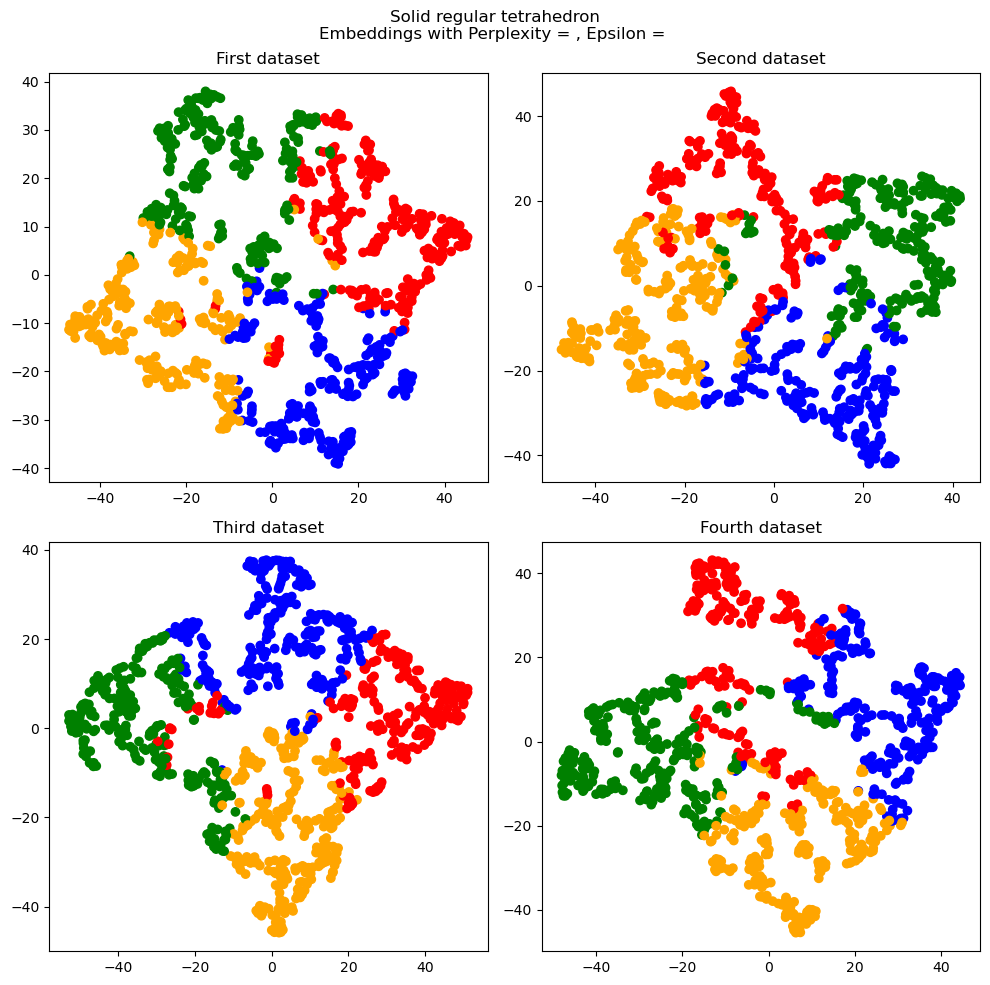

In [ ]:
# Plot solid tetrahedron embeddings
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Solid regular tetrahedron\nEmbeddings with Perplexity = 20, Epsilon = 5')

ax1 = fig.add_subplot(221)
ax1.scatter(solid_tetrahedron_embedding1[:, 0], solid_tetrahedron_embedding1[:, 1],
            c=point_colors)
ax1.set_title('First dataset')

ax2 = fig.add_subplot(222)
ax2.scatter(solid_tetrahedron_embedding2[:, 0], solid_tetrahedron_embedding2[:, 1],
            c=point_colors2)
ax2.set_title('Second dataset')

ax3 = fig.add_subplot(223)
ax3.scatter(solid_tetrahedron_embedding3[:, 0], solid_tetrahedron_embedding3[:, 1],
            c=point_colors3)
ax3.set_title('Third dataset')

ax4 = fig.add_subplot(224)
ax4.scatter(solid_tetrahedron_embedding4[:, 0], solid_tetrahedron_embedding4[:, 1],
            c=point_colors4)
ax4.set_title('Fourth dataset')
fig.tight_layout()

## 4. MNIST

## 2.1 Until the 24th of April

In [20]:
# Load all_data.RData
rdata = pyreadr.read_r(os.path.join(project_root, 'd_and_c', 'MNIST.RData'))

all_data_pixels = rdata["all_data_pixels"]
target = rdata["target"]
type_data = rdata["type_data"]

target = np.squeeze(np.array(target))
type_data = np.squeeze(np.array(type_data))

# Select train images of numbers
numeric_target = pd.to_numeric(target, errors="coerce")
train_idx = (type_data == "train") & (pd.notnull(numeric_target))

MNIST_pixels = all_data_pixels.loc[train_idx].values
MNIST_target = numeric_target[train_idx]

print(f"MNIST_pixels shape: {MNIST_pixels.shape}")
print(f"MNIST_target shape: {MNIST_target.shape}")

MNIST_pixels shape: (345035, 784)
MNIST_target shape: (345035,)


In [5]:
# Split data into two equally sized partitions
n_images = MNIST_target.shape[0]
shuffled_indices = np.random.permutation(n_images)
partitions_idx = np.array_split(shuffled_indices, 2)

MNIST_pixels1 = MNIST_pixels[partitions_idx[0],:]
MNIST_target1 = MNIST_target[partitions_idx[0]]

MNIST_pixels2 = MNIST_pixels[partitions_idx[1], :]
MNIST_target2 = MNIST_target[partitions_idx[1]]

print(f"Partition 1 pixels shape: {MNIST_pixels1.shape}, targets shape: {MNIST_target1.shape}")
print(f"Partition 2 pixels shape: {MNIST_pixels2.shape}, targets shape: {MNIST_target2.shape}")

Partition 1 pixels shape: (172518, 784), targets shape: (172518,)
Partition 2 pixels shape: (172517, 784), targets shape: (172517,)


In [6]:
# Apply t-SNE
%time MNIST_embedding1 = tsne(MNIST_pixels1, r=2, random_state=42, verbose=2)
%time MNIST_embedding2 = tsne(MNIST_pixels2, r=2, random_state=42, verbose=2)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=8, random_state=42, verbose=2)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 75.04 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 1.04 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 1.90 seconds
===> Running optimization with exaggeration=12.00, lr=14376.50 for 250 iterations...
Iteration   50, KL divergence 6.6395, 50 iterations in 2.5838 sec
Iteration  100, KL divergence 6.4172, 50 iterations in 2.6374 sec
Iteration  150, KL divergence 6.2970, 50 iterations in 2.5243 sec
Iteration  200, KL divergence 6.2271, 50 iterations in 2.4950 sec
Iteration  250, KL divergence 6.1896, 50 iterations in 2.5014 sec
   --> Time elapsed: 12.74 seconds
===> Running optimization with exaggeration=1

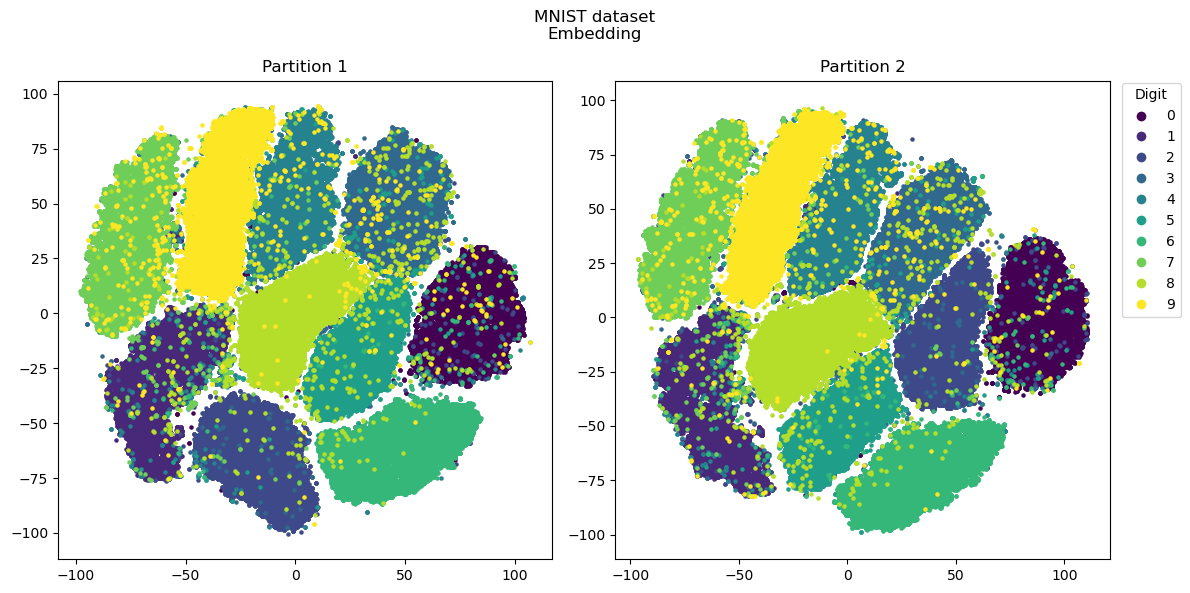

In [8]:
## Plot the t-SNE embedding
digits = np.unique(MNIST_target)
cmap = plt.get_cmap('viridis', len(digits))
# Create custom legend handles with larger markers
legend_handles = [mlines.Line2D([], [], linestyle='None', marker='o',
                                markersize=7,
                                markerfacecolor=cmap(i),
                                markeredgewidth=0,
                                label=int(digit))
                  for i, digit in enumerate(digits)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# Partition 1
for i, digit in enumerate(digits):
    mask = MNIST_target1 == digit
    ax1.scatter(MNIST_embedding1[mask, 0], MNIST_embedding1[mask, 1],
                color=cmap(i),
                label=int(digit),
                s=5)
ax1.set_title('Partition 1')
ax1.axis('equal')

# Partition 2
for i, digit in enumerate(digits):
    mask = MNIST_target2 == digit
    ax2.scatter(MNIST_embedding2[mask, 0], MNIST_embedding2[mask, 1],
                color=cmap(i),
                s=5)
ax2.set_title('Partition 2')
ax2.axis('equal')
ax2.legend(handles=legend_handles, title="Digit", bbox_to_anchor=(1.01, 1.01), loc='upper left')

fig.suptitle('MNIST dataset\nEmbedding')
plt.tight_layout()
plt.show()

### Check if parallelization works
This is crucial for systems with Apple Silicon, like the MacBook Pro used to run this notebook.

In [8]:
_, parallel_runtime = benchmark(tsne, MNIST_pixels1, r=2, random_state=42, n_jobs=os.cpu_count())
_, serial_runtime = benchmark(tsne, MNIST_pixels1, r=2, random_state=42, n_jobs=1)

print(f'Parallel runtime: {parallel_runtime}')
print(f'Serianl runtime: {serial_runtime}')

Parallel runtime: 142.61916133400518
Serianl runtime: 482.7203125829983


### 5000 images subset

We will now repeat the same experiment we performed on the other DR methods with a subset of 5000 images from MNIST.

Read pickled 5000-rows-subset instead of computing it again.

In [3]:
with open(os.path.join(project_root, 'd_and_c', 'MNIST_5000.pkl'), "rb") as f:
    bare_data = pickle.load(f)
    sampled_pixels1 = bare_data["pixels"]
    sampled_target1 = bare_data["target"]

In [4]:
MNIST_bare1, time_MNIST_bare1 = benchmark(tsne,
                                          sampled_pixels1, r=2, verbose=2)
# Save experiment results
with open(os.path.join(pickle_path, "MNIST_5000_tSNE.pkl"), "wb") as f:
    pickle.dump({"embedding": MNIST_bare1, "runtime": time_MNIST_bare1},
                f)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=-1, verbose=2)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 1.32 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.08 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.07 seconds
===> Running optimization with exaggeration=12.00, lr=416.67 for 250 iterations...
Iteration   50, KL divergence 4.2797, 50 iterations in 70.4113 sec
Iteration  100, KL divergence 4.3743, 50 iterations in 63.3202 sec
Iteration  150, KL divergence 4.3747, 50 iterations in 70.0156 sec
Iteration  200, KL divergence 4.3746, 50 iterations in 66.8332 sec
Iteration  250, KL divergence 4.3747, 50 iterations in 69.6830 sec
   --> Time elapsed: 340.27 seconds
===> Running optimization with exaggeration=1.00, lr=5000.

In [6]:
l, c_points = 1000, 100
MNIST_dc1, time_MNIST_dc1 = benchmark(divide_conquer,
                                      DRMethod.tSNE, sampled_pixels1, l=l, c_points=c_points, r=2, verbose=2)
# Save experiment results
with open(os.path.join(pickle_path, "MNIST_5000_DC_tSNE.pkl"), "wb") as f:
    pickle.dump({"embedding": MNIST_dc1, "runtime": time_MNIST_dc1},
                f)

Projecting partition 1...
--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=-1, verbose=2)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.15 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.01 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=12.00, lr=83.33 for 250 iterations...
Iteration   50, KL divergence 3.2542, 50 iterations in 9.2023 sec
Iteration  100, KL divergence 3.3047, 50 iterations in 7.9698 sec
Iteration  150, KL divergence 3.3093, 50 iterations in 7.9499 sec
Iteration  200, KL divergence 3.3075, 50 iterations in 7.9898 sec
Iteration  250, KL divergence 3.3037, 50 iterations in 8.0264 sec
   --> Time elapsed: 41.14 seconds
===> Running optimization with exaggera

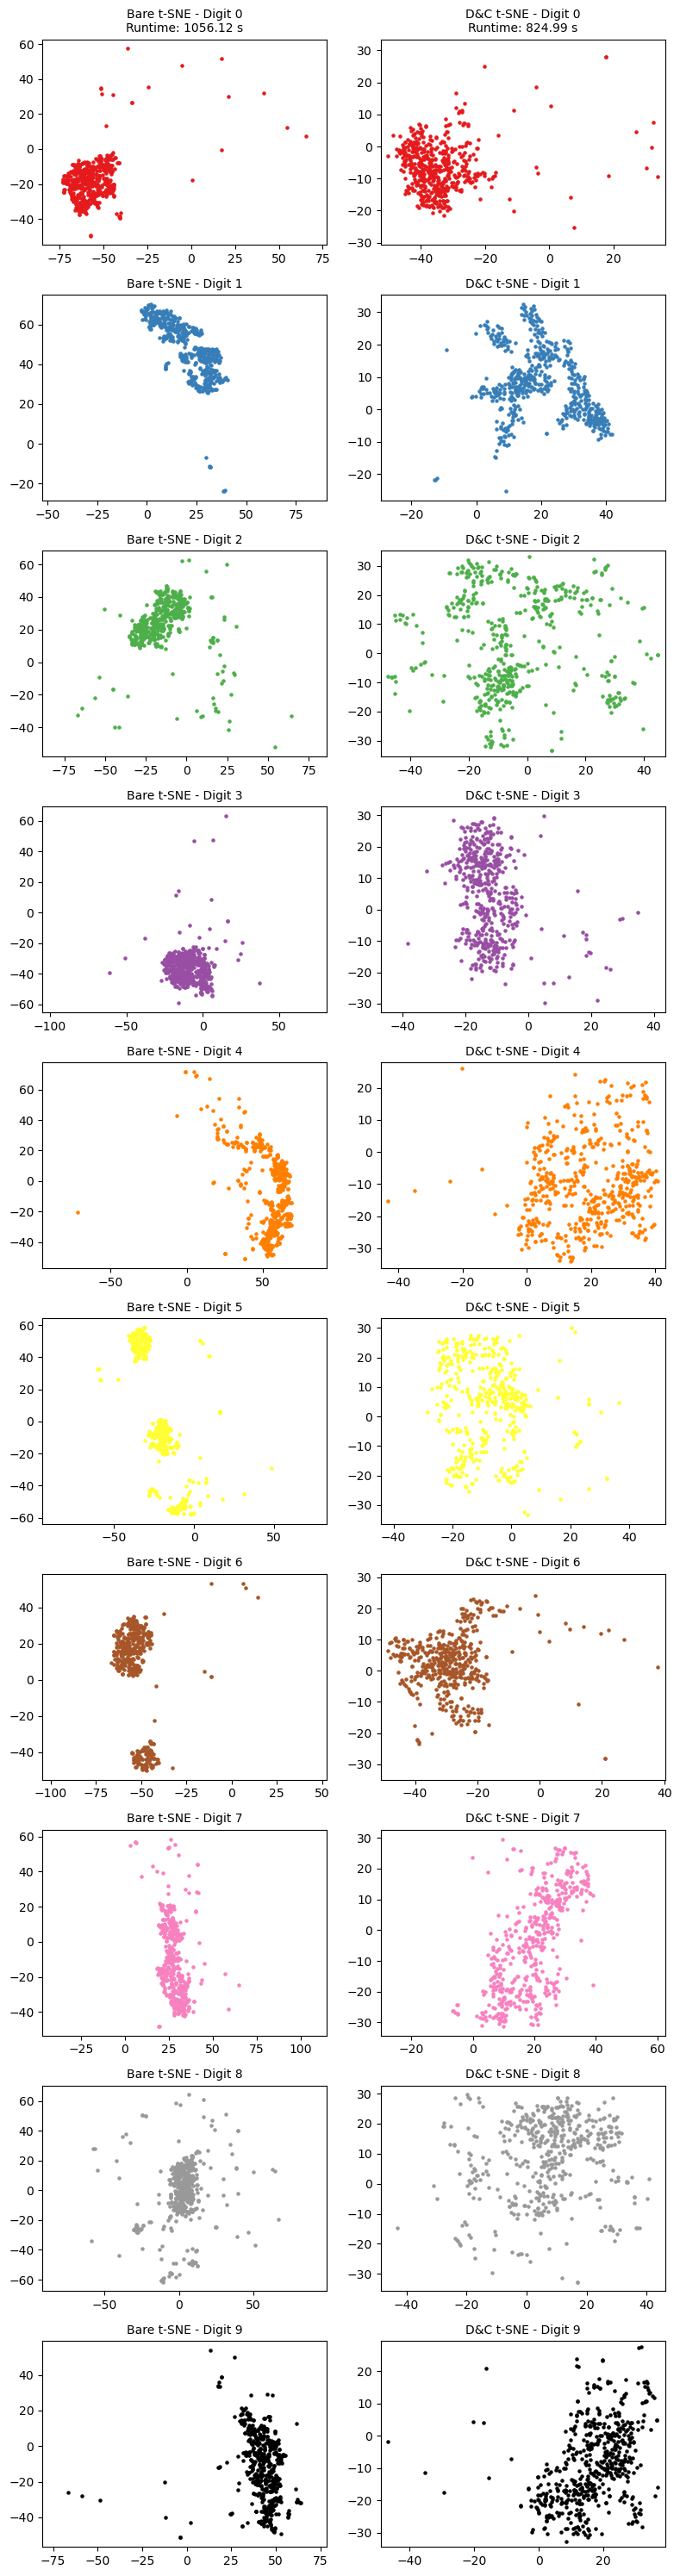

In [ ]:
# Load embeddings
with open(os.path.join(pickle_path, "MNIST_5000_tSNE.pkl"), "rb") as f:
    bare_data = pickle.load(f)
    MNIST_bare1 = bare_data["embedding"]
    time_MNIST_bare1 = bare_data["runtime"]

with open(os.path.join(pickle_path, "MNIST_5000_DC_tSNE.pkl"), "rb") as f:
    dc_data = pickle.load(f)
    MNIST_dc1 = dc_data["embedding"]
    time_MNIST_dc1 = dc_data["runtime"]

digits = np.unique(sampled_target1)

set1_colors = list(plt.get_cmap('Set1').colors)
set1_colors.append((0, 0, 0))  # Add black as RGB tuple
cmap = mcolors.ListedColormap(set1_colors)

# Create a 10x2 grid: one row per digit, columns for Bare and D&C
fig, axes = plt.subplots(len(digits), 2, figsize=(8, 30))
method_data = [
    ("Bare t-SNE", MNIST_bare1, time_MNIST_bare1),
    ("D&C t-SNE", MNIST_dc1, time_MNIST_dc1)
]

for row, digit in enumerate(digits):
    for col, (method_name, embedding, runtime) in enumerate(method_data):
        mask = sampled_target1 == digit
        ax = axes[row, col]
        ax.scatter(embedding[mask, 0], embedding[mask, 1],
                   color=cmap(row), s=5)
        if row == 0:
            ax.set_title(
                f"{method_name} - Digit {int(digit)}\nRuntime: {runtime:.2f} s", fontsize=10)
        else:
            ax.set_title(f"{method_name} - Digit {int(digit)}", fontsize=10)
        ax.axis('equal')
plt.tight_layout()
plt.show()

Next, we will apply a Procrustes transformation to digits 1-9 in order to align them with digit 0's embedding.

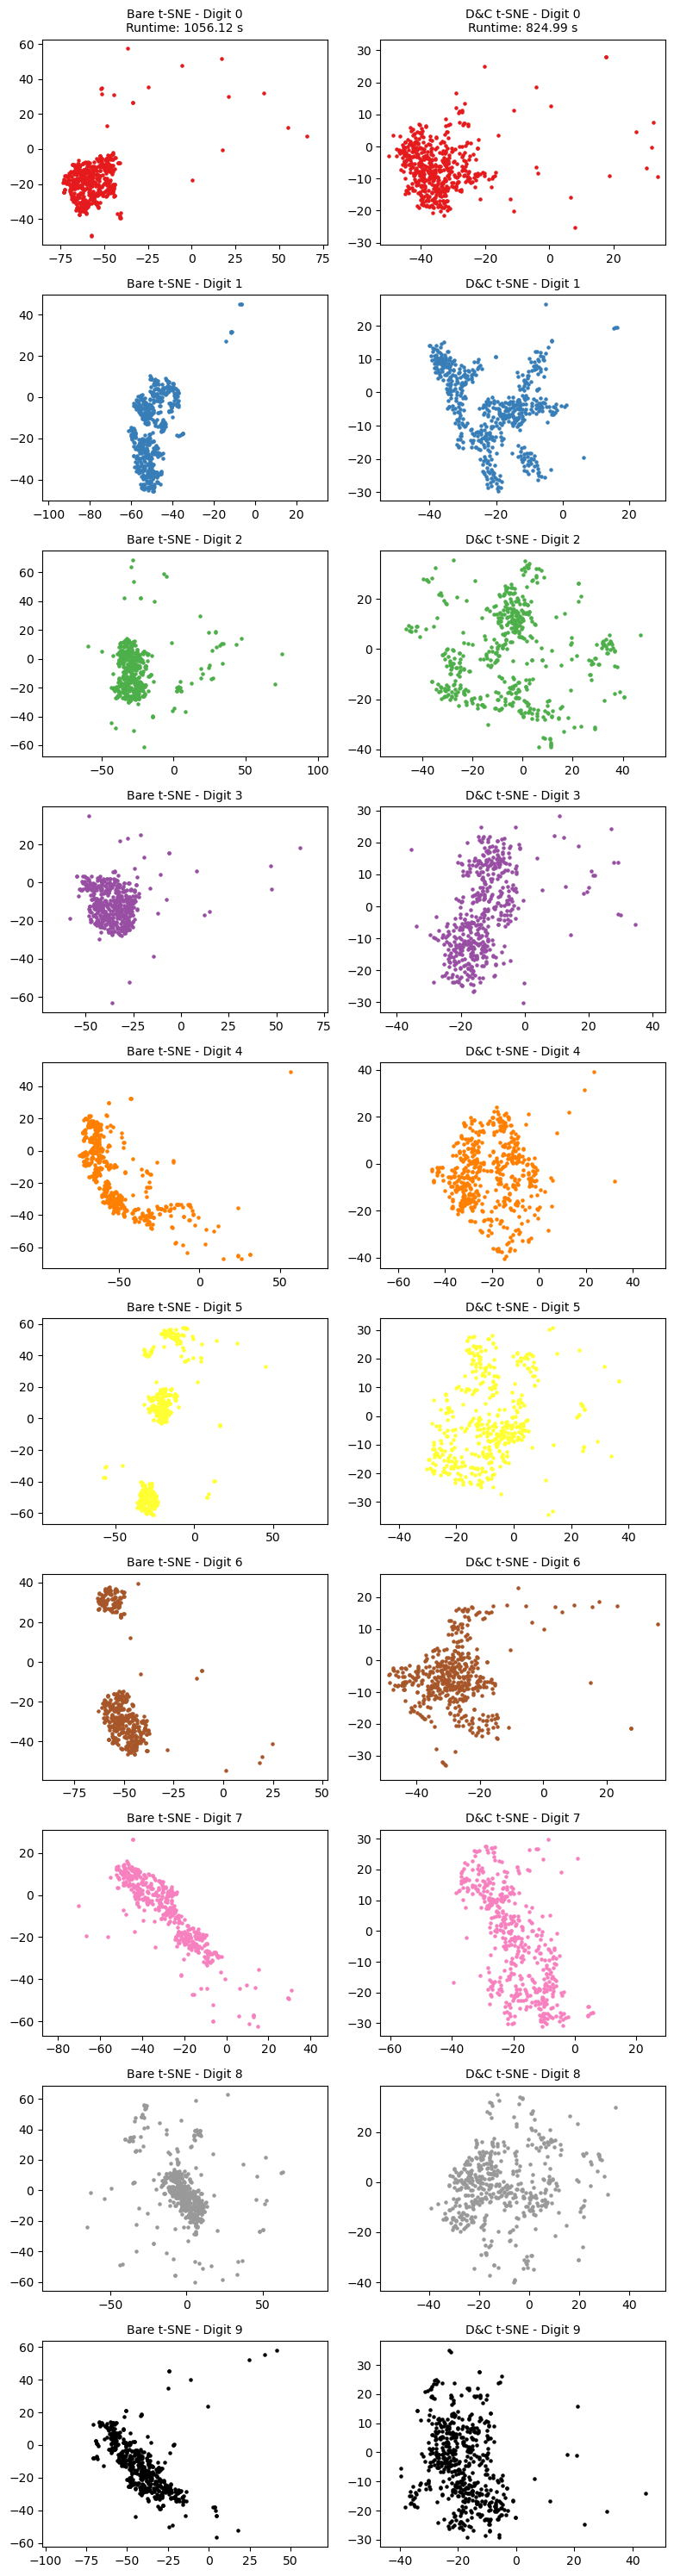

In [ ]:
digits = np.unique(sampled_target1)

set1_colors = list(plt.get_cmap('Set1').colors)
set1_colors.append((0, 0, 0))  # Add black as RGB tuple
cmap = mcolors.ListedColormap(set1_colors)


# Obtain target matrix to apply Procrustes transformation
digit_0 = MNIST_bare1[sampled_target1 == 0]
n_rows_target = digit_0.shape[0]

n_rows_digits = [MNIST_bare1[sampled_target1==digit].shape[0] for digit in digits]
c_points = min(n_rows_digits)

sampled_idx = np.random.choice(n_rows_target, size=c_points, replace=False)
target = digit_0[sampled_idx, :]

# Create a 10x2 grid: one row per digit, columns for Bare and D&C
fig, axes = plt.subplots(len(digits), 2, figsize=(8, 30))
method_data = [
    ("Bare t-SNE", MNIST_bare1, time_MNIST_bare1),
    ("D&C t-SNE", MNIST_dc1, time_MNIST_dc1)
]

for col, (method_name, embedding, runtime) in enumerate(method_data):
    # Obtain target matrix to apply Procrustes transformation
    digit_0 = embedding[sampled_target1 == 0]
    n_rows_target = digit_0.shape[0]

    n_rows_digits = [embedding[sampled_target1==digit].shape[0] for digit in digits]
    c_points = min(n_rows_digits)

    sampled_idx = np.random.choice(n_rows_target, size=c_points, replace=False)
    target = digit_0[sampled_idx, :]

    # Plot digit embeddings
    for row, digit in enumerate(digits):
        x = embedding[sampled_target1 == digit]
        ax = axes[row, col]
        if row == 0:
            ax.scatter(x[:,0], x[:, 1],
                       color=cmap(row), s=5)
            ax.set_title(
                f"{method_name} - Digit {int(digit)}\nRuntime: {runtime:.2f} s", fontsize=10)
        else:
            # Align x to y using perform_procrustes
            x_aligned = perform_procrustes(x[:c_points,:], target, x)
            ax.scatter(x_aligned[:,0], x_aligned[:,1],
                   color=cmap(row), s=5)
            ax.set_title(f"{method_name} - Digit {int(digit)}", fontsize=10)
        ax.axis('equal')
plt.tight_layout()
plt.show()

## 2.2 From the 25th of April

After 298 minutes, only 61 partitions had been embedded with l, c_points = 1000, 100. Since it would take too long to complete, we repeated the embedding with l, c_points = 10000, 1000, but after 34 min it had only embedded 1 partition. Therefore, we will perform a final embedding with l, c_points = 100000, 10000

In [8]:
l, c_points = 100000, 10000
MNIST_dc_full1, time_MNIST_dc_full1 = benchmark(divide_conquer,
                                                DRMethod.tSNE, MNIST_pixels, l=l, c_points=c_points, r=2, verbose=2)
# Save experiment results
with open(os.path.join(pickle_path, "MNIST_train_num_DC_tSNE.pkl"), "wb") as f:
    pickle.dump({"embedding": MNIST_dc_full1, "runtime": time_MNIST_dc_full1},
                f)

Projecting partition 1...
--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=-1, verbose=2)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 42.67 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 1.57 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 1.05 seconds
===> Running optimization with exaggeration=12.00, lr=8333.33 for 250 iterations...
Iteration   50, KL divergence 6.2176, 50 iterations in 1.6024 sec
Iteration  100, KL divergence 6.0484, 50 iterations in 1.4894 sec
Iteration  150, KL divergence 5.9228, 50 iterations in 1.4339 sec
Iteration  200, KL divergence 5.8608, 50 iterations in 1.4839 sec
Iteration  250, KL divergence 5.8359, 50 iterations in 1.4462 sec
   --> Time elapsed: 7.46 seconds
===> Running optimization with exagge

In [25]:
with open(os.path.join(pickle_path, "MNIST_train_num_DC_tSNE.pkl"), "rb") as f:
    bare_data = pickle.load(f)
    MNIST_dc_full1 = bare_data["embedding"]
    time_MNIST_dc_full1 = bare_data["runtime"]

In [21]:
# Estimate densities
digits = np.unique(MNIST_target)
densities = {}

for digit in digits:
    mask = MNIST_target == digit
    data = MNIST_dc_full1[mask].T
    kde = gaussian_kde(data)
    densities[int(digit)] = kde

In [27]:
n, l, c_points = 5000, 100000, 10000

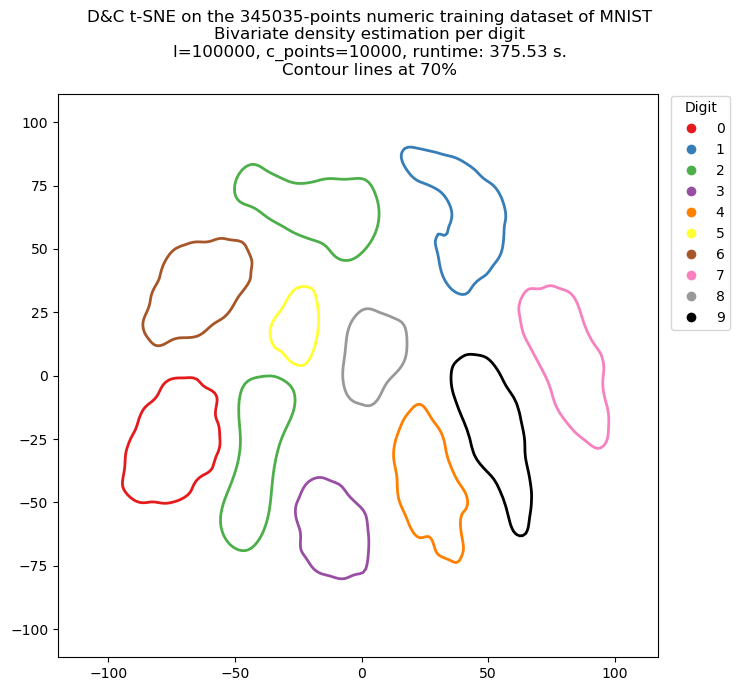

In [ ]:
# Contour plot estimated densities
set1_colors = list(plt.get_cmap('Set1').colors)
set1_colors.append((0, 0, 0))  # Add black
cmap = mcolors.ListedColormap(set1_colors)

# Compute meshgrid for contours
embedding_x = MNIST_dc_full1[:,0]
embedding_y = MNIST_dc_full1[:,1]
xpad = (embedding_x.max() - embedding_x.min()) * 0.05
ypad = (embedding_y.max() - embedding_y.min()) * 0.05
xmin, xmax = embedding_x.min() - xpad, embedding_x.max() + xpad
ymin, ymax = embedding_y.min() - ypad, embedding_y.max() + ypad
xx, yy = np.meshgrid(
    np.linspace(xmin, xmax, 200),
    np.linspace(ymin, ymax, 200)
)

fig, ax = plt.subplots(1, 1, figsize=(7.5, 7))
contour_level = 0.7

for i, digit in enumerate(digits):
    kde = densities[int(digit)]
    zz = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)
    ax.contour(xx, yy, zz, levels=[zz.max() * contour_level], colors=[cmap(i)], linewidths=2)
ax.axis('equal')
legend_handles = [mlines.Line2D([], [], linestyle='None', marker='o',
                                markersize=7,
                                markerfacecolor=cmap(i),
                                markeredgewidth=0,
                                label=int(digit))
                    for i, digit in enumerate(digits)]
ax.legend(handles=legend_handles, title="Digit",
            bbox_to_anchor=(1.01, 1.01), loc='upper left')
fig.suptitle(
    f"D&C t-SNE on the {MNIST_target.shape[0]}-points numeric training dataset of MNIST\nBivariate density estimation per digit\nl={l}, c_points={c_points}, runtime: {time_MNIST_dc_full1:.2f} s.\nContour lines at {contour_level*100:.0f}%")
plt.tight_layout()

In [18]:
# Load data and embeddings
with open(os.path.join(project_root, 'd_and_c', 'MNIST_5000.pkl'), "rb") as f:
    bare_data = pickle.load(f)
    sampled_pixels1 = bare_data["pixels"]
    sampled_target1 = bare_data["target"]

with open(os.path.join(pickle_path, "MNIST_5000_tSNE.pkl"), "rb") as f:
    bare_data = pickle.load(f)
    MNIST_bare1 = bare_data["embedding"]
    time_MNIST_bare1 = bare_data["runtime"]

with open(os.path.join(pickle_path, "MNIST_5000_DC_tSNE.pkl"), "rb") as f:
    dc_data = pickle.load(f)
    MNIST_dc1 = dc_data["embedding"]
    time_MNIST_dc1 = dc_data["runtime"]

Compute Pearson correlation between embeddings' dimensions of each digit.

In [5]:
digits = np.unique(sampled_target1)
correlations = {"Digit": [], "Corr_dim1": [], "Corr_dim2": []}

for digit in digits:
    mask = sampled_target1 == digit
    bare = MNIST_bare1[mask]
    dc = MNIST_dc1[mask]
    corr_dim0 = pearsonr(bare[:, 0], dc[:, 0])[0]
    corr_dim1 = pearsonr(bare[:, 1], dc[:, 1])[0]
    correlations["Digit"].append(int(digit))
    correlations["Corr_dim1"].append(corr_dim0)
    correlations["Corr_dim2"].append(corr_dim1)

df_corr = pd.DataFrame(correlations)
display(df_corr)

,Digit,Corr_dim1,Corr_dim2
0,0,0.714649,0.300955
1,1,0.095899,0.003654
2,2,0.512952,0.040760
3,3,0.420016,-0.043786
4,4,0.122497,0.744891
5,5,-0.077244,-0.041261
6,6,0.374776,0.095967
7,7,-0.168339,0.689544
8,8,0.521687,0.213425
9,9,0.233375,0.823928


In [6]:
# Total correlation
print(f'Total correlation of dim1: {pearsonr(MNIST_bare1[:, 0], MNIST_dc1[:, 0])[0]}')
print(f'Total correlation of dim2: {pearsonr(MNIST_bare1[:, 1], MNIST_dc1[:, 1])[0]}')

Total correlation of dim1: 0.8170763484715383
Total correlation of dim2: 0.32817864544487557


Estimate bivariate densities of each digit for both embeddings after applying a Procrustes transformation.

In [4]:
# Apply procrustes
digits_unique = np.unique(sampled_target1)
MNIST_dc1_procrustes = np.empty_like(
    MNIST_dc1)  # Initialize array for results

for digit_val in digits_unique:
    mask = (sampled_target1 == digit_val)

    bare_subset_digit = MNIST_bare1[mask]
    dc_subset_digit = MNIST_dc1[mask]

    # Get c_points of x and target
    c_points = min(
        bare_subset_digit.shape[0], dc_subset_digit.shape[0])

    x_ref = dc_subset_digit[:c_points, :]
    target_ref = bare_subset_digit[:c_points, :]

    aligned_dc_subset_digit = perform_procrustes(
        x_ref, target_ref, dc_subset_digit)
    MNIST_dc1_procrustes[mask] = aligned_dc_subset_digit

In [5]:
# Estimate densities
digits = np.unique(sampled_target1)
densities = {}

for method_name, embedding in [("Bare tSNE", MNIST_bare1), ("D&C tSNE", MNIST_dc1_procrustes)]:
    densities[method_name] = {}
    for digit in digits:
        mask = sampled_target1 == digit
        data = embedding[mask].T
        kde = gaussian_kde(data)
        densities[method_name][int(digit)] = kde

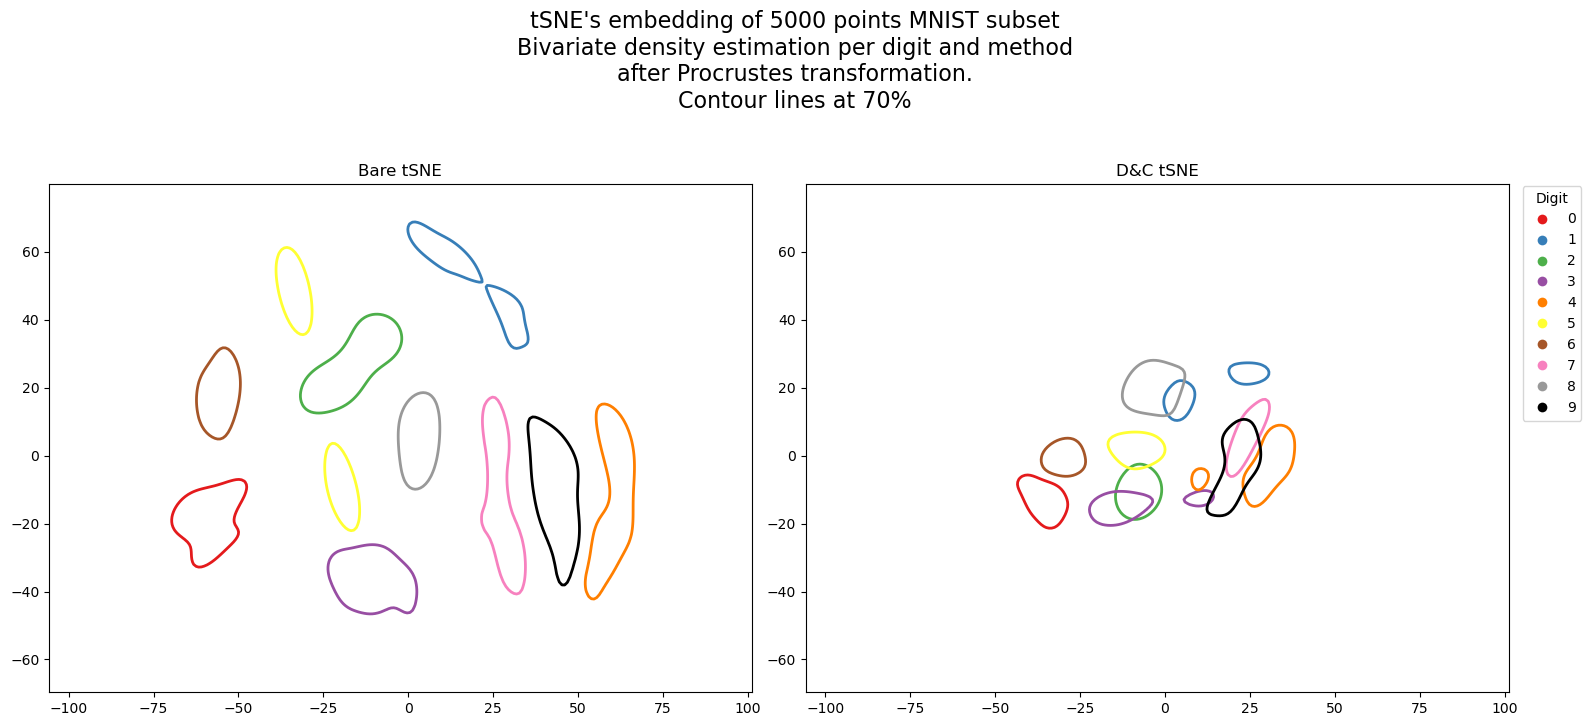

In [ ]:
# Contour plot estimated densities
n = 5000
set1_colors = list(plt.get_cmap('Set1').colors)
set1_colors.append((0, 0, 0))  # Add black if needed
cmap = mcolors.ListedColormap(set1_colors)

method_names = ["Bare tSNE", "D&C tSNE"]
embeddings = [MNIST_bare1, MNIST_dc1_procrustes]

# Compute meshgrid for contours
all_x = np.concatenate([emb[:, 0] for emb in embeddings])
all_y = np.concatenate([emb[:, 1] for emb in embeddings])
xpad = (all_x.max() - all_x.min()) * 0.05
ypad = (all_y.max() - all_y.min()) * 0.05
xmin, xmax = all_x.min() - xpad, all_x.max() + xpad
ymin, ymax = all_y.min() - ypad, all_y.max() + ypad
xx, yy = np.meshgrid(
    np.linspace(xmin, xmax, 200),
    np.linspace(ymin, ymax, 200)
)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))
contour_level = 0.7

for col, method in enumerate(method_names):
    ax = axes[col]
    for i, digit in enumerate(digits):
        kde = densities[method][int(digit)]
        zz = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)
        ax.contour(xx, yy, zz, levels=[zz.max() * contour_level], colors=[cmap(i)], linewidths=2)
    ax.set_title(f"{method}")
    ax.axis('equal')
    if col == 1:
        # Custom legend on the right plot
        legend_handles = [mlines.Line2D([], [], linestyle='None', marker='o',
                                        markersize=7,
                                        markerfacecolor=cmap(i),
                                        markeredgewidth=0,
                                        label=int(digit))
                          for i, digit in enumerate(digits)]
        ax.legend(handles=legend_handles, title="Digit",
                  bbox_to_anchor=(1.01, 1.01), loc='upper left')
fig.suptitle(
    f"tSNE's embedding of {n} points MNIST subset\nBivariate density estimation per digit and method\nafter Procrustes transformation.\nContour lines at {contour_level*100:.0f}%", fontsize=16, y=1.03)
plt.tight_layout()
plt.show()

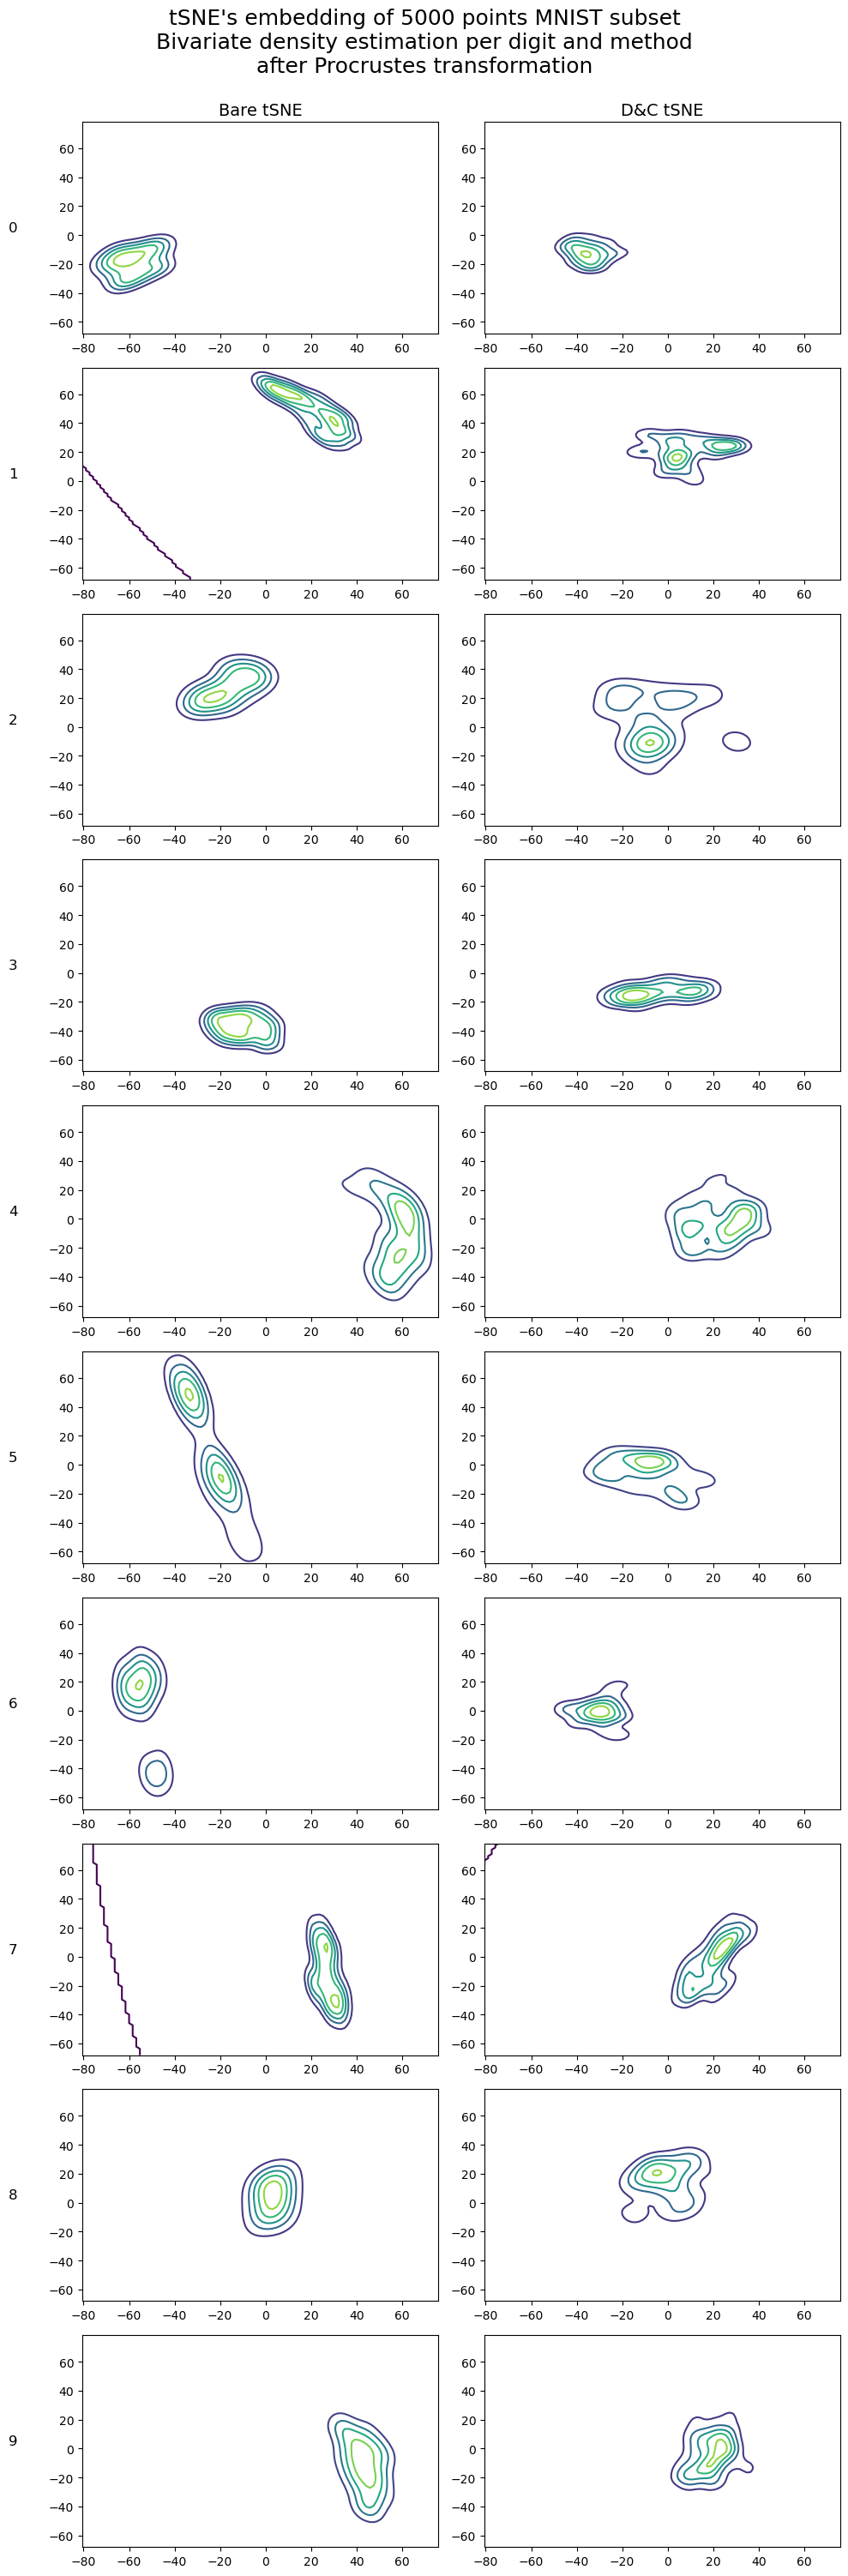

In [7]:
# Compare each digit with more contour lines
digits = np.unique(sampled_target1)
method_names = ["Bare tSNE", "D&C tSNE"]
embeddings = [MNIST_bare1, MNIST_dc1_procrustes]

# Compute meshgrid across all digits and methods
all_x = np.concatenate([emb[:, 0] for emb in embeddings])
all_y = np.concatenate([emb[:, 1] for emb in embeddings])
xpad = (all_x.max() - all_x.min()) * 0.05
ypad = (all_y.max() - all_y.min()) * 0.05
xmin, xmax = all_x.min() - xpad, all_x.max() + xpad
ymin, ymax = all_y.min() - ypad, all_y.max() + ypad

xx, yy = np.meshgrid(
    np.linspace(xmin, xmax, 100),
    np.linspace(ymin, ymax, 100)
)

# Create plot grid
fig, axes = plt.subplots(len(digits), len(method_names), figsize=(
    10, 30), sharex=False, sharey=False)
for row, digit in enumerate(digits):
    for col, method in enumerate(method_names):
        ax = axes[row, col]
        kde = densities[method][int(digit)]
        zz = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)
        ax.contour(xx, yy, zz, levels=5, cmap='viridis')
        if col == 0:
            ax.set_ylabel(f"{int(digit)}", fontsize=12,
                          rotation=0, labelpad=30, va='center')
        if row == 0:
            ax.set_title(method_names[col], fontsize=14)
fig.suptitle(f"tSNE's embedding of {n} points MNIST subset\nBivariate density estimation per digit and method\nafter Procrustes transformation",
             fontsize=18, y=1)
plt.tight_layout()
plt.show()

## 5. Swiss Roll

In [7]:
# Generate dataset
n = 1000
swiss_roll, color = make_swiss_roll(n_samples=n, random_state=42)

In [11]:
# Apply t-SNE
%time tsne_swiss_roll = tsne(swiss_roll, perplexity=30, n_iter=5000, learning_rate=10, random_state=42)

CPU times: user 6min, sys: 1h 2min 46s, total: 1h 8min 47s
Wall time: 18min 18s


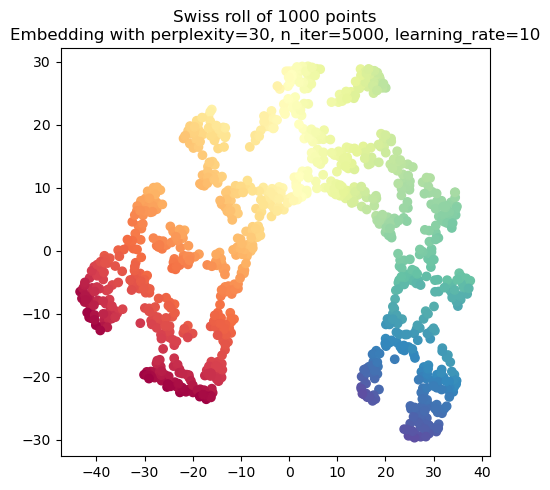

In [14]:
# Plot the t-SNE embedding
plt.figure(figsize=(5, 5))
plt.scatter(tsne_swiss_roll[:, 0], tsne_swiss_roll[:,
            1], c=color, cmap=plt.cm.Spectral)
plt.title(f'Swiss roll of {n} points\nEmbedding with perplexity=30, n_iter=5000, learning_rate=10')
plt.tight_layout()
plt.show()